In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sqlite
import os
from tqdm import tqdm
import math
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn import svm
from glob import glob
import adtk
from adtk.data import validate_series
import matplotlib.pyplot as plt
from datetime import datetime
import shutil
from pyod.models.copod import COPOD
# pyod库

In [2]:
# onclassSVM异常检测算法
def OneClassSVM_wash(data,del_rate = 0.05,gam=0.01,show=False):
    model = svm.OneClassSVM(nu=del_rate,kernel="rbf",gamma=gam)
    result = model.fit(data[["WIND_SPEED","POWER"]]).predict(data[["WIND_SPEED","POWER"]])
    good_idx = result==1
    bad_idx = result==-1
    good_data =  data.loc[good_idx,:]
    bad_data = data.loc[bad_idx,:]
    if show==True:
        plt.figure(figsize=(10, 6))
        plt.scatter(good_data["WIND_SPEED"], good_data["POWER"])
        plt.scatter(bad_data["WIND_SPEED"], bad_data["POWER"])
        plt.xlabel("WIND_SPEED")
        plt.ylabel("POWER")
        plt.show()
    raise NameError
    return good_data

In [3]:
# 换出风功率曲线
def plot_power_wind(data):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:,0], data[:,1])
    plt.xlabel("speed")
    plt.ylabel("power")
    plt.show()

In [4]:
file_name_list = glob(".\\37_trainset\\*.csv")
farm_list = []
for file_name in file_name_list:
    farm_list.append(file_name.split("\\")[-1].split("_")[0])
print(farm_list)

['XZWGSAAQ580', 'XZWGSAAQ626', 'XZWGSAAQ774', 'XZWGSAAQ863', 'XZWGXAAQ127', 'XZWHEAAQ039', 'XZWHEAFS274', 'XZWHNAAQ751', 'XZWHNAAQ780', 'XZWHNAFS505', 'XZWIMAAQ287', 'XZWIMAAQ431', 'XZWIMAAQ816', 'XZWJSAAQ314', 'XZWJSAAQ599', 'XZWJSAAQ976', 'XZWNXAAQ168', 'XZWNXAAQ171', 'XZWNXAAQ419', 'XZWNXAAQ551', 'XZWNXAAQ756', 'XZWNXAAQ961', 'XZWQHAAQ498', 'XZWSDAGJ361', 'XZWSDAGJ976', 'XZWSNAAQ510', 'XZWSXAAQ357', 'XZWSXAFS033', 'XZWXJAAQ053', 'XZWXJAAQ101', 'XZWXJAAQ140', 'XZWXJAAQ247', 'XZWXJAAQ378', 'XZWXJAAQ510', 'XZWXJAAQ559', 'XZWXJAAQ910', 'XZWXJAAQ962']


In [5]:
# 读取测试集数据(不需要清洗)
def read_test_data(farm_name,root_dir,end_wash_time):
    csv_data = pd.read_csv(os.path.join(root_dir,"{}_{}.csv".format(farm_name,"testset")),
                                 usecols=["DATETIME","WIND_SPEED","POWER","Cap"])
    csv_data["DATETIME"] = pd.to_datetime(csv_data["DATETIME"],format="%Y/%m/%d %H:%M:%S")
    csv_data.fillna(-99,inplace=True)
    csv_data  = csv_data.loc[csv_data["DATETIME"]>=end_wash_time,:]
    csv_data["DATETIME"] = csv_data["DATETIME"].apply(lambda x:datetime.strftime(x,"%d/%m/%Y %H:%M:%S"))
    return csv_data

In [6]:
from adtk.visualization import plot
from adtk.detector import AutoregressionAD
# 自回归时序异常检测方法
def adtk_function(train_info_data,show=False):
    adtk_data = train_info_data[["DATETIME","POWER"]]
    adtk_data.index = train_info_data["DATETIME"]
    adtk_data.drop(["DATETIME"],axis=1,inplace=True)
    adtk_data = validate_series(adtk_data)
    
    detector = AutoregressionAD()
    anomalies = detector.fit_detect(adtk_data)
    good_idx = anomalies.iloc[:,0].values == 0
    bad_idx =  anomalies.iloc[:,0].values == 1
    assert len(anomalies)==len(train_info_data)
    good_data = train_info_data.loc[good_idx,:]
    bad_data = train_info_data.loc[bad_idx,:]
    #adtk.visualization.plot(adtk_data,anomaly=anomalies,anomaly_color="red",anomaly_tag="marker")
    if(show==True):
        plt.rcParams["figure.figsize"]=(20,5)
        SHOW_NUM=2000
        show_data = train_info_data.iloc[:SHOW_NUM,:]
        bad_idx = bad_idx[:SHOW_NUM]
        show_data["i"] = list(range(len(show_data)))
        #plt.figure(figsize=(10, 6))
        plt.plot(show_data["i"],show_data["POWER"])
        plt.scatter(show_data.loc[bad_idx,"i"],show_data.loc[bad_idx,"POWER"],color="r")
        plt.show()
    return good_data

In [34]:
#原始COPOD异常检测算法
def pyod_function(data,show=False):
    clf = COPOD()
    clf.fit(data[["WIND_SPEED","POWER"]])
    judge_point = -1
    #==============================
#     y_train_scores =  clf.decision_scores_
#     sorted_score = np.sort(y_train_scores)
#     judge_point = sorted_score[int(len(sorted_score)*0.95)]
#     good_idx = y_train_scores < judge_point
#     bad_idx =y_train_scores >= judge_point
    #==============================
#==================================
    y_label = clf.labels_
    good_idx = y_label==0
    bad_idx = y_label==1
#=================================
    good_data =  data.loc[good_idx,:]
    bad_data = data.loc[bad_idx,:]
    print("judge_point:{} good_num:{} bad_num:{}".format(judge_point,len(good_data),len(bad_data)))
    if show==True:
        plt.figure(figsize=(20, 12))
        plt.scatter(good_data["WIND_SPEED"], good_data["POWER"],s=8)
        plt.scatter(bad_data["WIND_SPEED"], bad_data["POWER"],s=8)
        plt.xlabel("WIND_SPEED")
        plt.ylabel("POWER")
        plt.show()
    raise NameError
    return good_data

In [30]:
#改进的多阶段COPOD算法
def multi_stage_pyod_function(data,show=False):
    train_data = data.copy()
    final_bad_index = np.array(list(range(len(data))))
    #del_list = [0.8 for _ in range(15)]
    del_list = [0.7 for _  in range(9)]
    for del_rate in del_list:
        #==============================
        clf = COPOD()
        clf.fit(train_data[["WIND_SPEED","POWER"]])
        y_train_scores =  clf.decision_scores_
        sorted_score = np.sort(y_train_scores)
        judge_point = sorted_score[int(len(sorted_score)*(1-del_rate))]
        bad_idx = y_train_scores >= judge_point
        train_data = train_data.loc[bad_idx,:]
        final_bad_index = final_bad_index[bad_idx]
        print(len(train_data)/len(data))
        #==============================
    bad_idx = list(final_bad_index)
    all_idx = list(range(len(data)))
    good_idx = set(all_idx)-set(bad_idx)
    good_idx = list(good_idx)
    assert len(good_idx)+len(bad_idx)==len(all_idx)
    col_name = data.columns
    data = data.values
    good_data = data[good_idx,:]
    bad_data = data[bad_idx,:]
    good_data = pd.DataFrame(good_data,columns=col_name)
    bad_data = pd.DataFrame(bad_data,columns=col_name)

    print("judge_point:{} good_num:{} bad_num:{}".format(judge_point,len(good_data),len(bad_data)))
    if show==True:
        plt.figure(figsize=(20, 12))
        plt.scatter(good_data["WIND_SPEED"], good_data["POWER"],s=8)
        plt.scatter(bad_data["WIND_SPEED"], bad_data["POWER"],s=8)
        plt.xlabel("WIND_SPEED")
        plt.ylabel("POWER")
        plt.show()
    return good_data

In [31]:
from pyod.models import knn
# KNN异常检测算法
def pyod_KNN(data,show=False):
    clf = knn.KNN(contamination=0.05,n_neighbors=5)
    clf.fit(data[["WIND_SPEED","POWER"]])
    judge_point = -1
    #==============================
#     y_train_scores =  clf.decision_scores_
#     sorted_score = np.sort(y_train_scores)
#     judge_point = sorted_score[int(len(sorted_score)*0.95)]
#     good_idx = y_train_scores < judge_point
#     bad_idx =y_train_scores >= judge_point
    #==============================
#==================================
    y_label = clf.labels_
    good_idx = y_label==0
    bad_idx = y_label==1
#=================================
    good_data =  data.loc[good_idx,:]
    bad_data = data.loc[bad_idx,:]
    print("judge_point:{} good_num:{} bad_num:{}".format(judge_point,len(good_data),len(bad_data)))
    if show==True:
        plt.figure(figsize=(20, 12))
        plt.scatter(good_data["WIND_SPEED"], good_data["POWER"],s=8)
        plt.scatter(bad_data["WIND_SPEED"], bad_data["POWER"],s=8)
        plt.xlabel("WIND_SPEED")
        plt.ylabel("POWER")
        plt.show()
    return good_data

In [32]:
def plot_test_data(test_data):
    plt.figure(figsize=(20, 12))
    plt.scatter(test_data["WIND_SPEED"], test_data["POWER"],s=1)
    plt.xlabel("WIND_SPEED")
    plt.ylabel("POWER")
    plt.show()

2018-05-01 00:00:00 2019-12-29 00:00:00 2019-12-29 00:00:00


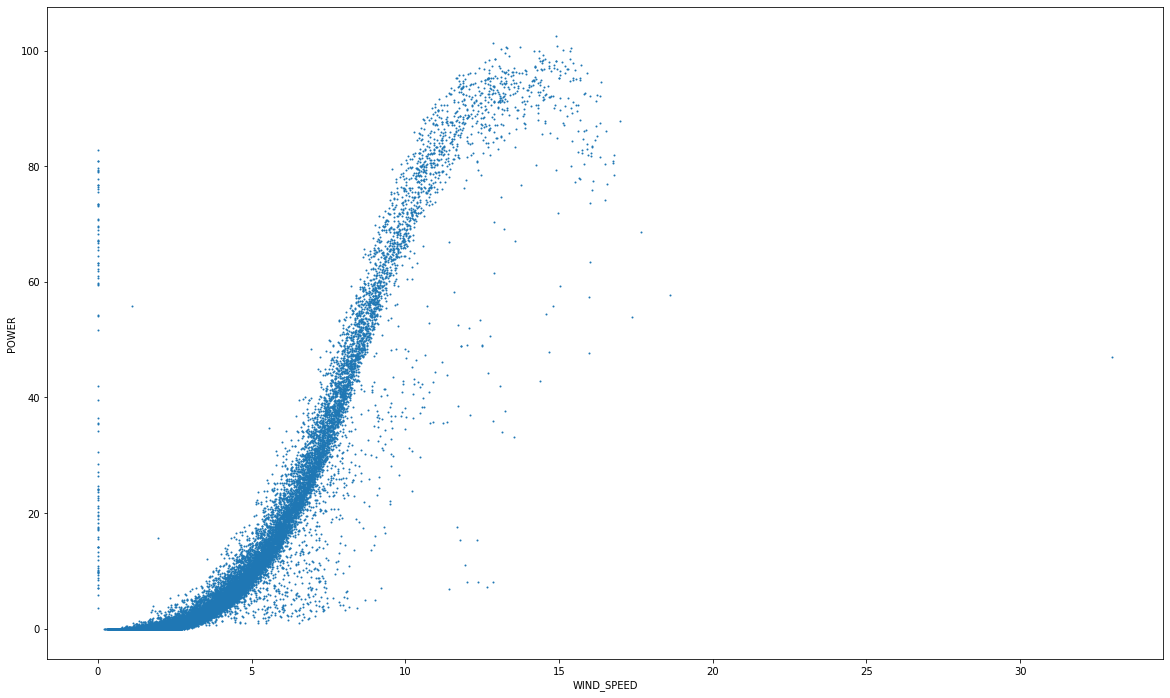

judge_point:-1 good_num:51172 bad_num:5686


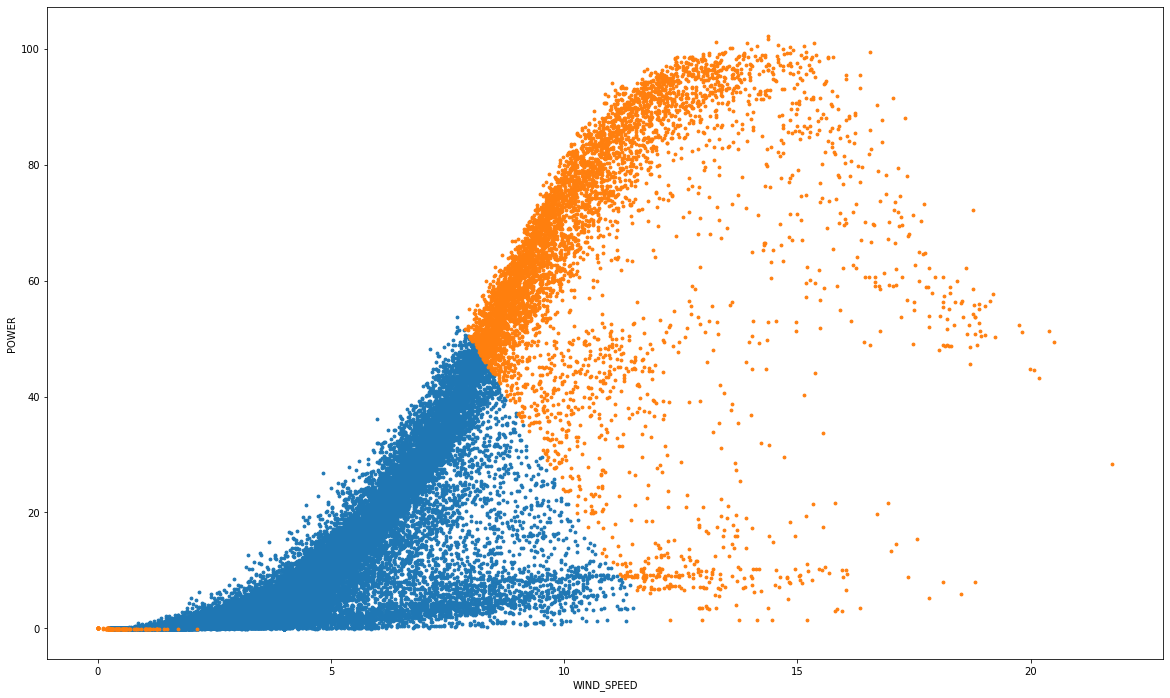

NameError: 

In [35]:
start_wash_time = datetime.strptime("2020-01-01",'%Y-%m-%d')
end_wash_time = datetime.strptime("2020-09-01",'%Y-%m-%d')
end_time = datetime.strptime("2020-10-14",'%Y-%m-%d')
result_format = "SJQXT0_info.csv"
# 异常检测主流程，并生成符合格式的收资数据
for farm in farm_list:
    info_data = pd.read_csv(os.path.join(".\\37_trainset","{}_{}.csv".format(farm,"trainset")),usecols=["DATETIME","WIND_SPEED","POWER","Cap"])
    info_data["DATETIME"] = pd.to_datetime(info_data["DATETIME"],format="%Y/%m/%d %H:%M:%S")
    #读进来的就是37个场站的训练集 全洗，更改各个时间点==========
    start_wash_time = info_data["DATETIME"].iloc[0]
    end_wash_time = info_data["DATETIME"].iloc[-1]+np.timedelta64(15,"m")
    end_time = info_data["DATETIME"].iloc[-1]+np.timedelta64(15,"m")
    print(start_wash_time,end_wash_time,end_time)
    #===========================================================
    need_idx1 = info_data["DATETIME"]>=start_wash_time
    need_idx2 = info_data["DATETIME"]<end_time
    info_data = info_data.loc[need_idx1&need_idx2,:]
    
    # 只洗训练集收资，不洗测试集的
    need_idx1 = info_data["DATETIME"]>=start_wash_time
    need_idx2 = info_data["DATETIME"]<end_wash_time
    train_info_data = info_data.loc[need_idx1&need_idx2,:]
    train_info_data.fillna(-99,inplace=True)
    need_idx1 = train_info_data["WIND_SPEED"]!=-99
    need_idx2 = train_info_data["POWER"]!=-99
    train_info_data = train_info_data.loc[need_idx1&need_idx2,:]
    test_info_data = read_test_data(farm_name=farm,root_dir=".\\37_testset",end_wash_time=end_wash_time)
    plot_test_data(test_info_data)
    

    #plot_power_wind(train_info_data[["WIND_SPEED","POWER"]].values)
    # 调用不同的异常点检测算法
    #====================================================================================
    #train_info_good_data = OneClassSVM_wash(train_info_data,del_rate = 0.05,gam = 0.01,show=True)
    #train_info_good_data = OneClassSVM_wash(train_info_data,del_rate=0.05,gam=0.01,show=False)
    #train_info_good_data = LocalOutlierFactor_wash(train_info_data,del_rate = 0.05,neighbor_num=25,show=True)
    #train_info_good_data = IsolationForest_wash(train_info_data)
    train_info_good_data = pyod_function(train_info_data,show=True)
    print("留存率:",len(train_info_good_data)/len(train_info_data))
    raise NameError
    #====================================================================================
    # 已经删除了一些异常点的数据，还要把这些时间点补回来，填充-99,
    time_list = list(pd.date_range(start=start_wash_time,end=end_wash_time,freq='900s'))
    # end是闭区间所以要去除最后一个时间点
    time_list = time_list[:-1]
    train_info_data = pd.DataFrame({"DATETIME":time_list,"speed":[-99]*len(time_list),
                                   "direction":[-99]*len(time_list),"real_power":[-99]*len(time_list),
                                   "forcast_power":[-99]*len(time_list)})
    train_info_data = pd.merge(train_info_data,train_info_good_data[["DATETIME","POWER"]],on="DATETIME",how="left")
    train_info_data["real_power"] = train_info_data["POWER"]
    train_info_data.drop("POWER",axis=1,inplace=True)
    train_info_data.fillna(-99,inplace=True)
    data_columns = list(train_info_data.columns)
    data_columns[0]="datatime"
    train_info_data.columns = data_columns
    train_info_data["datatime"] = train_info_data["datatime"].apply(lambda x:datetime.strftime(x,"%d/%m/%Y %H:%M:%S"))
    
    save_test_data = pd.DataFrame({"datatime":[-99]*len(test_info_data), "speed":[-99]*len(test_info_data),
                                   "direction":[-99]*len(test_info_data),"real_power":[-99]*len(test_info_data),
                                   "forcast_power":[-99]*len(test_info_data)})
    
    save_test_data["datatime"] = test_info_data["DATETIME"]
    save_test_data["real_power"] = test_info_data["POWER"]

    print(farm,datetime.strptime(train_info_data["datatime"].iloc[-1],'%d/%m/%Y %H:%M:%S'),
         datetime.strptime(save_test_data["datatime"].iloc[0],'%d/%m/%Y %H:%M:%S'))
    assert(datetime.strptime(train_info_data["datatime"].iloc[-1],'%d/%m/%Y %H:%M:%S')< \
           datetime.strptime(save_test_data["datatime"].iloc[0],'%d/%m/%Y %H:%M:%S'))
    train_info_data = train_info_data.append(save_test_data)
    train_info_data.to_csv("./washed_datav4_KNN/{}{}".format(farm,result_format),index=None)

In [ ]:
# #将原始数据复制到备份,只用备份W001 和 W002 因为做特征筛选试验只用W001 和 W002
# DATABASE_DIR = "..\\data"
# BACKUP_DIR = "..\\数据备份\\xz37_T0(info)"
# for weather in ["info"]:
#     file_dir_list = glob(".\\washed_datav1\\*.csv")
#     print(file_dir_list)
#     for file_dir in file_dir_list:
#         file_name = file_dir.split("\\")[-1]
#         farm_name = file_name.split("_")[0]
#         source_dir = os.path.join(DATABASE_DIR,farm_name,file_name)
#         if not os.path.exists(os.path.join(BACKUP_DIR,farm_name)):
#             os.mkdir(os.path.join(BACKUP_DIR,farm_name))

#         target_dir = os.path.join(BACKUP_DIR,farm_name,file_name)
#         try:
#             shutil.copyfile(source_dir,target_dir)
#         except IOError:
#             print(target_dir)

In [ ]:
# 将备份的还原到
DATABASE_DIR = "..\\data"
BACKUP_DIR = "..\\数据备份\\xz37_T0(info)"
for weather in ["info"]:
    file_dir_list = glob(".\\washed_datav1\\*.csv")
    print(file_dir_list)
    for file_dir in file_dir_list:
        file_name = file_dir.split("\\")[-1]
        farm_name = file_name.split("_")[0]
        source_dir = os.path.join(BACKUP_DIR,farm_name,file_name)
        
        target_dir = os.path.join(DATABASE_DIR,farm_name,file_name)
        try:
            shutil.copyfile(source_dir,target_dir)
        except IOError:
            print(target_dir)

In [ ]:
# 将洗完的数据复制到database
DATABASE_DIR = "..\\data"
for weather in ["info"]:
    file_dir_list = glob(".\\washed_datav4_KNN\\*.csv")
    for file_dir in file_dir_list:
        file_name = file_dir.split("\\")[-1]
        farm_name = file_name.split("_")[0]
        source_dir = file_dir
        target_dir = os.path.join(DATABASE_DIR,farm_name,file_name)
        print(target_dir)
        try:
            shutil.copyfile(source_dir,target_dir)
        except IOError:
            print("error==============>",target_dir)